# 동서발전 태양광 발전량 예측 AI 경진대회

## 0. Module Import

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings(action='ignore')

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Data

In [2]:
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('data/ulsan_fcst_data.csv')
dangjin_obs = pd.read_csv('data/dangjin_obs_data.csv')
ulsan_obs = pd.read_csv('data/ulsan_obs_data.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
dangjin_rain = pd.read_csv('data2/석문면_6시간강수량_20180301_20210301.csv')
dangjin_snow = pd.read_csv('data2/석문면_6시간적설_20180301_20210301.csv')
dangjin_rain3 = pd.read_csv('data2/석문면_강수확률_20180301_20210301.csv')
ulsan_rain = pd.read_csv('data2/신정4동_6시간강수량_20180301_20210301.csv')
ulsan_snow = pd.read_csv('data2/신정4동_6시간적설_20180301_20210301.csv')
ulsan_rain3 = pd.read_csv('data2/신정4동_강수확률_20180301_20210301.csv')

### energy 데이터 전처리

In [4]:
energy.isna().sum()

time                  0
dangjin_floating     24
dangjin_warehouse    48
dangjin               0
ulsan                 0
dtype: int64

In [5]:
# 3월 1일 데이터 제거
energy = energy.drop(range(24)).reset_index(drop=True)
# 결측값이 있는 인덱스 저장
idx1 = energy[energy['dangjin_floating'].isna()==True].index
idx2 = energy[energy['dangjin_warehouse'].isna()==True].index
# obs 데이터에 없는 2018년 7월 24일 11시부터 2018년 7월 16일 관측값 인덱스 혹시몰라 저장
idx3 = energy[(energy['time']>='2018-07-24 11:00:00')&(energy['time']<='2018-07-24 16:00:00')].index

# 발전량 데이터에서 저장한 인덱스 제거
energy = energy.drop(idx1)
energy = energy.drop(idx2).reset_index(drop=True)
energy = energy.drop(25535)

In [6]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-02 1:00:00,0.0,0.0,0,0
1,2018-03-02 2:00:00,0.0,0.0,0,0
2,2018-03-02 3:00:00,0.0,0.0,0,0
3,2018-03-02 4:00:00,0.0,0.0,0,0
4,2018-03-02 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25530,2021-01-31 19:00:00,0.0,0.0,0,0
25531,2021-01-31 20:00:00,0.0,0.0,0,0
25532,2021-01-31 21:00:00,0.0,0.0,0,0
25533,2021-01-31 22:00:00,0.0,0.0,0,0


### fcst 데이터 전처리

In [7]:
def fcst_split_14(fcst_df):
    
    # 14시 예보 기준 다음 날 예보 데이터 생성
    fcst_df['Forecast_time'] = pd.to_datetime(fcst_df['Forecast time']) # 타입 변환
    fcst_14 = fcst_df[fcst_df['Forecast_time'].dt.hour==14] # 2시기준 예보 데이터 저장
    fcst_14 = fcst_14[(fcst_14['forecast']>=10)&(fcst_14['forecast']<=33)]
    fcst_14['Forecast_time'] = fcst_14['Forecast_time'] + fcst_14['forecast'].map(lambda x: pd.DateOffset(hours=x))
    fcst_14 = fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    fcst_14 = fcst_14[fcst_14['Forecast_time']<='2021-03-01 00:00:00']
    fcst_14_ = pd.DataFrame()
    fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 00:00:00', freq='H')
    fcst_14_df = pd.merge(fcst_14_, fcst_14, on='Forecast_time', how='outer')
    fcst_14_df = fcst_14_df.interpolate()
    fcst_14_df = fcst_14_df.drop(0).reset_index(drop=True)
    
    # 2018년 3월 2일 ~ 2021년 1월 31일 (train)
    fcst_train = fcst_14_df[fcst_14_df['Forecast_time']<'2021-02-01 00:00:00']
    fcst_train = fcst_train[fcst_train['Forecast_time']>='2018-03-02 01:00:00']
    fcst_train['Forecast_time'] = fcst_train['Forecast_time'].astype(str)
    #fcst_train = fcst_train.replace('2021-02-01 00:00:00', '2021-01-31 24:00:00')
    fcst_train = fcst_train.drop(idx1)
    fcst_train = fcst_train.drop(idx2).reset_index(drop=True)
    fcst_train.index = range(fcst_train.shape[0])
    
    # 2021년 2월 1일 ~ 2021년 2월 28일 데이터 (test)
    fcst_test = fcst_14_df[fcst_14_df['Forecast_time']>='2021-02-01 01:00:00']
    fcst_test['Forecast_time'] = fcst_test['Forecast_time'].astype(str)
    #fcst_test = fcst_test.replace('2021-03-01 00:00:00', '2021-02-28 24:00:00')
    fcst_test.index = range(fcst_test.shape[0])
    return fcst_train, fcst_test

In [8]:
dangjin_train_fcst, dangjin_test_fcst = fcst_split_14(dangjin_fcst)
ulsan_train_fcst, ulsan_test_fcst = fcst_split_14(ulsan_fcst)

In [9]:
dangjin_train_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 01:00:00,-2.666667,55.000000,6.300000,337.000000,1.0
1,2018-03-02 02:00:00,-3.333333,55.000000,5.900000,338.000000,1.0
2,2018-03-02 03:00:00,-4.000000,55.000000,5.500000,339.000000,1.0
3,2018-03-02 04:00:00,-4.333333,56.666667,5.100000,340.666667,1.0
4,2018-03-02 05:00:00,-4.666667,58.333333,4.700000,342.333333,1.0
...,...,...,...,...,...,...
25530,2021-01-31 19:00:00,5.666667,76.666667,3.266667,170.666667,4.0
25531,2021-01-31 20:00:00,5.333333,78.333333,3.433333,167.333333,4.0
25532,2021-01-31 21:00:00,5.000000,80.000000,3.600000,164.000000,4.0
25533,2021-01-31 22:00:00,5.333333,80.000000,4.266667,168.333333,4.0


In [10]:
dangjin_test_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2021-02-01 01:00:00,6.333333,83.333333,5.200000,188.666667,4.0
1,2021-02-01 02:00:00,6.666667,86.666667,4.800000,200.333333,4.0
2,2021-02-01 03:00:00,7.000000,90.000000,4.400000,212.000000,4.0
3,2021-02-01 04:00:00,6.666667,91.666667,3.900000,213.333333,4.0
4,2021-02-01 05:00:00,6.333333,93.333333,3.400000,214.666667,4.0
...,...,...,...,...,...,...
667,2021-02-28 20:00:00,7.666667,65.000000,1.733333,150.333333,4.0
668,2021-02-28 21:00:00,7.000000,70.000000,1.900000,54.000000,4.0
669,2021-02-28 22:00:00,6.666667,70.000000,1.633333,57.000000,4.0
670,2021-02-28 23:00:00,6.333333,70.000000,1.366667,60.000000,4.0


### obs 데이터 전처리

In [11]:
def obs_processing(obs_df):
    # 전운량 결측치 0으로 대체 후 나머지 결측치는 ffill
    obs_df['전운량(10분위)'] = obs_df['전운량(10분위)'].fillna(0)
    obs_df = obs_df.fillna(method='ffill')
    obs_df = obs_df.rename({'일시':'Forecast_time', '기온(°C)':'Temperature', '풍속(m/s)':'WindSpeed', 
                            '풍향(16방위)':'WindDirection', '습도(%)':'Humidity', '전운량(10분위)':'Cloud'}, axis='columns')
    obs_df = obs_df[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    obs_df['Forecast_time'] = pd.to_datetime(obs_df['Forecast_time'])
    obs_df = obs_df[obs_df['Forecast_time']>='2018-03-02 01:00:00']
    obs_df = obs_df.drop(idx1)
    obs_df = obs_df.drop(idx2)
    
    # 2018년 7월 24일 11시~16시 데이터가 누락되었으므로 7월 25일 데이터로 대체
    obs_0724 = pd.DataFrame(columns=obs_df.columns)
    obs_0724 = obs_df[(obs_df['Forecast_time']>='2018-07-25 11:00:00')&(
        obs_df['Forecast_time']<='2018-07-25 16:00:00')]
    obs_0724['Forecast_time'] = pd.date_range(start='2018-07-24 11:00:00', periods=6, freq='H')
    obs_df = pd.concat([obs_df, obs_0724])
    obs_df = obs_df.sort_values(by='Forecast_time', ascending=True)
    obs_df['Forecast_time'] = obs_df['Forecast_time'].astype(str)
    obs_df.index = range(obs_df.shape[0])
    return obs_df

In [12]:
dangjin_obs = obs_processing(dangjin_obs)
ulsan_obs = obs_processing(ulsan_obs)

In [13]:
dangjin_obs

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 01:00:00,-2.8,53.0,3.8,360.0,0.0
1,2018-03-02 02:00:00,-3.2,52.0,2.5,360.0,0.0
2,2018-03-02 03:00:00,-3.5,50.0,2.6,20.0,0.0
3,2018-03-02 04:00:00,-4.2,55.0,1.4,50.0,0.0
4,2018-03-02 05:00:00,-5.1,59.0,0.8,70.0,0.0
...,...,...,...,...,...,...
25530,2021-01-31 19:00:00,6.7,75.0,1.5,200.0,8.0
25531,2021-01-31 20:00:00,6.2,77.0,0.8,200.0,8.0
25532,2021-01-31 21:00:00,5.3,82.0,0.7,230.0,8.0
25533,2021-01-31 22:00:00,5.8,77.0,1.0,200.0,8.0


### fcst vs obs

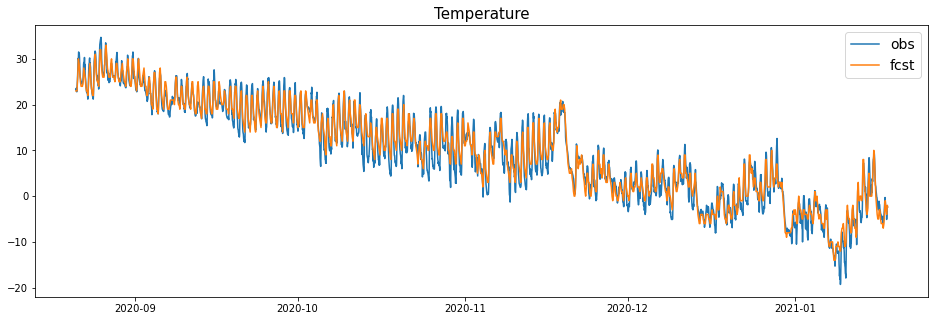

In [14]:
plt.figure(figsize=(16, 5))
plt.plot(pd.to_datetime(dangjin_obs.loc[24*900:24*1050, 'Forecast_time']), 
         dangjin_obs.loc[24*900:24*1050, 'Temperature'], label='obs')
plt.plot(pd.to_datetime(dangjin_train_fcst.loc[24*900:24*1050, 'Forecast_time']), 
         dangjin_train_fcst.loc[24*900:24*1050, 'Temperature'], label='fcst')
plt.title('Temperature', fontsize=15)
plt.legend(prop={'size':14}, loc='best')
plt.show()

# 2. Feature Engineering

In [15]:
def make_calendar_feature(fcst_df):
    
    # 예보 시간 및 날짜 정보 feature로 추가
    fcst_df['date'] = fcst_df['Forecast_time'].str.split(' ').str[0]
    fcst_df['hour'] = fcst_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    fcst_df['year'] = fcst_df['date'].str.split('-').str[0].astype(int)
    fcst_df['month'] = fcst_df['date'].str.split('-').str[1].astype(int)
    fcst_df['day'] = fcst_df['date'].str.split('-').str[2].astype(int)
    fcst_df = fcst_df[['Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud',
                       'hour', 'year', 'month', 'day']]
    return fcst_df

In [16]:
dangjin_train_fcst = make_calendar_feature(dangjin_train_fcst)
ulsan_train_fcst = make_calendar_feature(ulsan_train_fcst)
dangjin_test_fcst = make_calendar_feature(dangjin_test_fcst)
ulsan_test_fcst = make_calendar_feature(ulsan_test_fcst)
dangjin_train_fcst

,Temperature,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day
0,-2.666667,55.000000,6.300000,337.000000,1.0,1,2018,3,2
1,-3.333333,55.000000,5.900000,338.000000,1.0,2,2018,3,2
2,-4.000000,55.000000,5.500000,339.000000,1.0,3,2018,3,2
3,-4.333333,56.666667,5.100000,340.666667,1.0,4,2018,3,2
4,-4.666667,58.333333,4.700000,342.333333,1.0,5,2018,3,2
...,...,...,...,...,...,...,...,...,...
25530,5.666667,76.666667,3.266667,170.666667,4.0,19,2021,1,31
25531,5.333333,78.333333,3.433333,167.333333,4.0,20,2021,1,31
25532,5.000000,80.000000,3.600000,164.000000,4.0,21,2021,1,31
25533,5.333333,80.000000,4.266667,168.333333,4.0,22,2021,1,31


In [17]:
def make_sky3_feature(fcst_df, typ):
    dangjin_rain_14 = fcst_df[fcst_df['hour']==1400.0]
    dangjin_rain_14 = dangjin_rain_14[(dangjin_rain_14['forecast']>=10)&(dangjin_rain_14['forecast']<=33)]
    dangjin_rain_14['hour'] = -10.0
    dangjin_rain_14['hour'] = dangjin_rain_14['hour'] + dangjin_rain_14['forecast']
    dangjin_rain_14 = dangjin_rain_14[(dangjin_rain_14['hour']>=0)&(dangjin_rain_14['hour']<=24)]
    dangjin_rain_14 = dangjin_rain_14.drop([162172, 162173, 162174, 162175, 162176, 162177, 162178, 162179, 
                                            162321, 162322, 162323, 162324, 162325, 162326, 162327, 162328
                                           ]).reset_index(drop=True)
    dangjin_rain_14_df = pd.DataFrame()
    dangjin_rain_14_df['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', 
                                                        end='2021-02-28 21:00:00', freq='3H')
    dangjin_rain_14_df = pd.concat([dangjin_rain_14_df, dangjin_rain_14], axis=1)
    dangjin_rain_df = pd.DataFrame()
    dangjin_rain_df['Forecast_time'] = pd.date_range(start='2018-03-02 01:00:00', 
                                                     end='2021-03-01 00:00:00', freq='H')
    dangjin_rain_df = pd.merge(dangjin_rain_df, dangjin_rain_14_df, on='Forecast_time', how='outer')
    dangjin_rain_df = dangjin_rain_df.drop(26280)
    dangjin_rain_df = dangjin_rain_df.drop(idx1)
    dangjin_rain_df = dangjin_rain_df.drop(idx2).reset_index(drop=True)
    dangjin_rain_df = dangjin_rain_df.interpolate()
    dangjin_rain_df = dangjin_rain_df.iloc[:, [0, 4]]
    dangjin_rain_df.columns = ['Forecast_time', typ]
    dangjin_rain_df = dangjin_rain_df.fillna(method='bfill')
    dangjin_rain_train = dangjin_rain_df.iloc[:-24*28-1, 1]
    dangjin_rain_test = dangjin_rain_df.iloc[-24*28:, 1].reset_index(drop=True)
    
    return dangjin_rain_train, dangjin_rain_test

In [18]:
dangjin_rain3_train, dangjin_rain3_test = make_sky3_feature(dangjin_rain3, 'rain3')
ulsan_rain3_train, ulsan_rain3_test = make_sky3_feature(ulsan_rain3, 'rain3')

In [19]:
dangjin_train_fcst = pd.concat([dangjin_train_fcst, dangjin_rain3_train], axis=1)
ulsan_train_fcst = pd.concat([ulsan_train_fcst, ulsan_rain3_train], axis=1)
dangjin_test_fcst = pd.concat([dangjin_test_fcst, dangjin_rain3_test], axis=1)
ulsan_test_fcst = pd.concat([ulsan_test_fcst, ulsan_rain3_test], axis=1)
dangjin_train_fcst

,Temperature,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day,rain3
0,-2.666667,55.000000,6.300000,337.000000,1.0,1,2018,3,2,0.0
1,-3.333333,55.000000,5.900000,338.000000,1.0,2,2018,3,2,0.0
2,-4.000000,55.000000,5.500000,339.000000,1.0,3,2018,3,2,0.0
3,-4.333333,56.666667,5.100000,340.666667,1.0,4,2018,3,2,0.0
4,-4.666667,58.333333,4.700000,342.333333,1.0,5,2018,3,2,0.0
...,...,...,...,...,...,...,...,...,...,...
25530,5.666667,76.666667,3.266667,170.666667,4.0,19,2021,1,31,60.0
25531,5.333333,78.333333,3.433333,167.333333,4.0,20,2021,1,31,60.0
25532,5.000000,80.000000,3.600000,164.000000,4.0,21,2021,1,31,60.0
25533,5.333333,80.000000,4.266667,168.333333,4.0,22,2021,1,31,50.0


In [20]:
def make_sky6_feature(fcst_df, typ):
    dangjin_rain_14 = fcst_df[fcst_df['hour']==1400.0]
    dangjin_rain_14 = dangjin_rain_14[(dangjin_rain_14['forecast']>=10)&(dangjin_rain_14['forecast']<=33)]
    dangjin_rain_14['hour'] = -10.0
    dangjin_rain_14['hour'] = dangjin_rain_14['hour'] + dangjin_rain_14['forecast']
    dangjin_rain_14 = dangjin_rain_14[(dangjin_rain_14['hour']>=0)&(dangjin_rain_14['hour']<=24)]
    dangjin_rain_14 = dangjin_rain_14.drop([83295, 83296, 83297, 83298, 
                                            83372, 83373, 83374, 83375]).reset_index(drop=True)
    dangjin_rain_14_df = pd.DataFrame()
    dangjin_rain_14_df['Forecast_time'] = pd.date_range(start='2018-03-02 03:00:00', 
                                                        end='2021-03-01 00:00:00', freq='6H')
    dangjin_rain_14_df = pd.concat([dangjin_rain_14_df, dangjin_rain_14], axis=1)
    dangjin_rain_df = pd.DataFrame()
    dangjin_rain_df['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', 
                                                     end='2021-03-01 00:00:00', freq='H')
    dangjin_rain_df = pd.merge(dangjin_rain_df, dangjin_rain_14_df, on='Forecast_time', how='outer')
    
    dangjin_rain_df = dangjin_rain_df.drop(0).reset_index(drop=True)
    dangjin_rain_df = dangjin_rain_df.drop(idx1)
    dangjin_rain_df = dangjin_rain_df.drop(idx2).reset_index(drop=True)
    dangjin_rain_df = dangjin_rain_df.interpolate()
    dangjin_rain_df = dangjin_rain_df.iloc[:, [0, 4]]
    dangjin_rain_df.columns = ['Forecast_time', typ]
    dangjin_rain_df = dangjin_rain_df.fillna(method='bfill')

    dangjin_rain_train = dangjin_rain_df.iloc[:-24*28-1, 1]
    dangjin_rain_test = dangjin_rain_df.iloc[-24*28:, 1].reset_index(drop=True)
    
    return dangjin_rain_train, dangjin_rain_test

In [21]:
# dangjin_rain6_train, dangjin_rain6_test = make_sky6_feature(dangjin_rain, 'rain6')
# dangjin_snow6_train, dangjin_snow6_test = make_sky6_feature(dangjin_snow, 'snow6')
# ulsan_rain6_train, ulsan_rain6_test = make_sky6_feature(ulsan_rain, 'rain6')
# ulsan_snow6_train, ulsan_snow6_test = make_sky6_feature(ulsan_snow, 'snow6')

In [22]:
# dangjin_train_fcst = pd.concat([dangjin_train_fcst, dangjin_rain6_train, dangjin_snow6_train], axis=1)
# ulsan_train_fcst = pd.concat([ulsan_train_fcst, ulsan_rain6_train, ulsan_snow6_train], axis=1)
# dangjin_test_fcst = pd.concat([dangjin_test_fcst, dangjin_rain6_test, dangjin_snow6_test], axis=1)
# ulsan_test_fcst = pd.concat([ulsan_test_fcst, ulsan_rain6_test, ulsan_snow6_test], axis=1)
# dangjin_train_fcst

# 4. Modeling

In [23]:
def make_train_val(train_df, target_df, location):
    
    # 뒤 30일을 validation셋으로 설정
    train_x = train_df.iloc[:-24*30-1]
    train_y = target_df[location].iloc[:-24*30-1]
    val_x = train_df.iloc[-24*30:]
    val_y = target_df[location].iloc[-24*30:]
    
    return train_x, train_y, val_x, val_y

In [24]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)

    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

#### no 7.45 0.1<br>rain3 6.98 0.09 <br>rain6 X<br>

In [25]:
train_x, train_y, val_x, val_y = make_train_val(dangjin_train_fcst, energy, 'dangjin_floating') 
train_dataset1 = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
params1 = {'learning_rate': 0.09, 'objective': 'regression', 'metric':'logloss', 'seed':42}
dangjin_floating_model = lgb.train(params1, train_dataset1, 10000, val_dataset, feval=nmae_10, 
                                   verbose_eval=50, early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 24814, number of used features: 10
[LightGBM] [Info] Start training from score 123.133957
Training until validation scores don't improve for 50 rounds
[50]	valid_0's score: 7.73538
[100]	valid_0's score: 7.42834
[150]	valid_0's score: 7.23573
[200]	valid_0's score: 7.08207
[250]	valid_0's score: 7.00704
[300]	valid_0's score: 7.08931
Early stopping, best iteration is:
[257]	valid_0's score: 6.98937


#### no 9.54 0.09<br>rain3 9.13 0.006<br>rain6 X

In [26]:
train_x, train_y, val_x, val_y = make_train_val(dangjin_train_fcst, energy, 'dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
params2 = {'learning_rate': 0.006, 'objective': 'regression', 'metric':'logloss', 'seed':42}
dangjin_warehouse_model = lgb.train(params2, train_dataset, 10000, val_dataset, feval=nmae_10,
                                    verbose_eval=200, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 24814, number of used features: 10
[LightGBM] [Info] Start training from score 93.165794
Training until validation scores don't improve for 100 rounds
[200]	valid_0's score: 11.9762
[400]	valid_0's score: 10.2183
[600]	valid_0's score: 9.58964
[800]	valid_0's score: 9.34507
[1000]	valid_0's score: 9.2108
[1200]	valid_0's score: 9.13667
Early stopping, best iteration is:
[1217]	valid_0's score: 9.13323


#### no 9.764 0.009<br>rain3 9.306 0.07 <br>rain6 X

In [27]:
train_x, train_y, val_x, val_y = make_train_val(dangjin_train_fcst, energy, 'dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
params3 = {'learning_rate': 0.07, 'objective': 'regression', 'metric':'logloss', 'seed':42}
dangjin_model = lgb.train(params3, train_dataset, 10000, val_dataset, feval=nmae_10,
                                    verbose_eval=200, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 24814, number of used features: 10
[LightGBM] [Info] Start training from score 140.621061
Training until validation scores don't improve for 100 rounds
[200]	valid_0's score: 9.3357
Early stopping, best iteration is:
[199]	valid_0's score: 9.30693


#### no 5.92 0.09<br>rain3 6.05 0.06 <br>rain6 X

In [28]:
train_x, train_y, val_x, val_y = make_train_val(ulsan_train_fcst, energy, 'ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
params4 = {'learning_rate': 0.06, 'objective': 'regression', 'metric':'logloss', 'seed':42}
ulsan_model = lgb.train(params4, train_dataset, 10000, val_dataset, feval=nmae_10,
                                    verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 24814, number of used features: 10
[LightGBM] [Info] Start training from score 64.249013
Training until validation scores don't improve for 100 rounds
[100]	valid_0's score: 6.14655
[200]	valid_0's score: 6.113
Early stopping, best iteration is:
[148]	valid_0's score: 6.05387


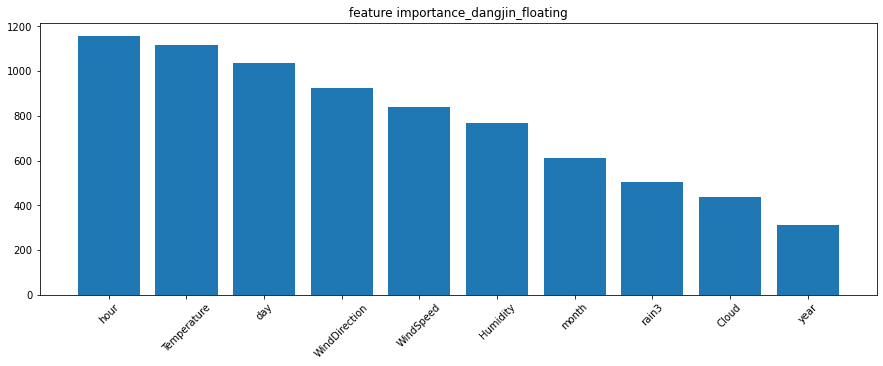

In [29]:
feature_importance = pd.DataFrame([val_x.columns, dangjin_floating_model.feature_importance()]).T
feature_importance.columns = ['feature', 'importance']
fi = feature_importance.sort_values(by=['importance'], ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(fi['feature'], fi['importance'])
ax.set_title('feature importance_dangjin_floating')
plt.xticks(rotation=45)
plt.show()

# 5. Predict

In [30]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test_fcst)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test_fcst)
dangjin_pred = dangjin_model.predict(dangjin_test_fcst)
ulsan_pred = ulsan_model.predict(ulsan_test_fcst)

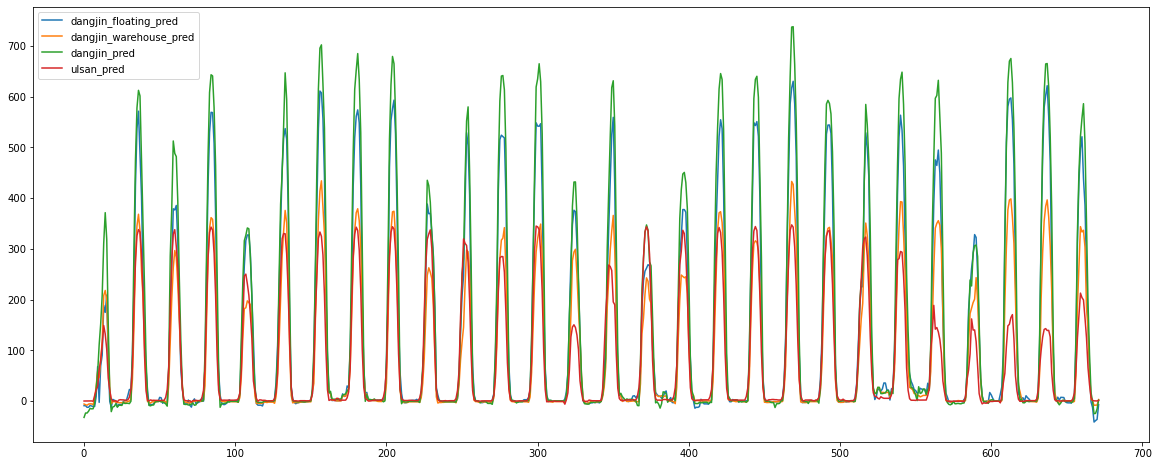

In [34]:
plt.figure(figsize=(20,8))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [32]:
sample_submission.iloc[:24*28, 1] = dangjin_floating_pred
sample_submission.iloc[:24*28, 2] = dangjin_warehouse_pred
sample_submission.iloc[:24*28, 3] = dangjin_pred
sample_submission.iloc[:24*28, 4] = ulsan_pred

In [33]:
sample_submission.to_csv('submission/dongwhan.csv', index=False)